# Generate data and calculate similarity

The goal of this notebook is to determine how much of the structure in the original dataset (single experiment) is retained after adding some number of experiments.

For this simulation experiment we wanted to capture the individual experiment structure.
In particular, we simulated data by (1) preserving the relationship between samples within an experiment but (2) shifting the samples in space.

Criteria (1) will account for the type of experiment, such as treatment vs non-treatment.  Criteria (2) will reflect a different type of perturbation, like a different antibiotic.  

The approach is to,
1. Randomly sample an experiment from the Pseudomonas compendium
2. Embed samples from the experiment into the trained latent space
3. Randomly shift the samples to a new location in the latent space. This new location will be selected based on the distribution of samples in the latent space 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import random

import warnings
warnings.filterwarnings(action='ignore')

from plotnine import ggplot, ggtitle, xlab, ylab, geom_point, geom_line, aes, ggsave

sys.path.append("../")
from functions import generate_data
from functions import similarity_metric

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# User parameters
NN_architecture = 'NN_2500_30'
analysis_name = 'analysis_1'
num_simulated_experiments = 100
lst_num_partitions = [1,2,3,5,10,20,30,50,70,100]
use_pca = True
num_PCs = 10

In [3]:
# Input files

# base dir on repo
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../..")) 

# base dir on local machine for data storage
# os.makedirs doesn't recognize `~`
local_dir = local_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../..")) 

NN_dir = base_dir + "/models/" + NN_architecture

normalized_data_file = os.path.join(
    base_dir,
    "data",
    "input",
    "train_set_normalized.pcl")

In [4]:
# Output file
svcca_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "svcca.pdf")

### Load file with experiment ids

In [5]:
experiment_ids_file = os.path.join(
    base_dir,
    "data",
    "metadata",
    "experiment_ids.txt")

### Generate simulated data

In [6]:
# Generate simulated data
generate_data.simulate_compendium(experiment_ids_file, 
                                  num_simulated_experiments,
                                  normalized_data_file,
                                  NN_architecture,
                                  analysis_name
                                 )

Creating new directory: 
 /home/alexandra/Documents/Data/Batch_effects/simulated/analysis_1


Normalized gene expression data contains 950 samples and 5549 genes
Return: simulated gene expression data containing 765 samples and 5550 genes


In [7]:
# Simulated data file 
simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

In [8]:
# Read in data
simulated_data = pd.read_table(
    simulated_data_file,
    header=0,
    index_col=0,
    sep='\t')

simulated_data.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
GSM199982.CEL,0.646,0.706,0.399,0.642,0.419,0.292,0.424,0.468,0.454,0.496,...,0.535,0.604,0.489,0.526,0.263,0.378,0.444,0.572,0.655,E-GEOD-8083
GSM199983.CEL,0.648,0.706,0.402,0.644,0.424,0.294,0.417,0.469,0.451,0.495,...,0.540,0.611,0.494,0.529,0.266,0.382,0.448,0.577,0.657,E-GEOD-8083
GSM199984.CEL,0.598,0.670,0.433,0.638,0.443,0.364,0.367,0.447,0.433,0.506,...,0.529,0.601,0.487,0.499,0.330,0.392,0.494,0.587,0.636,E-GEOD-8083
GSM199985.CEL,0.614,0.695,0.455,0.667,0.445,0.357,0.364,0.465,0.458,0.481,...,0.542,0.606,0.498,0.509,0.304,0.400,0.500,0.595,0.645,E-GEOD-8083
GSM199986.CEL,0.606,0.680,0.444,0.652,0.446,0.362,0.364,0.456,0.444,0.494,...,0.536,0.605,0.494,0.504,0.318,0.398,0.498,0.593,0.642,E-GEOD-8083


In [9]:
normalized_data = pd.read_table(
        normalized_data_file,
        header=0,
        sep='\t',
        index_col=0).T

normalized_data.head()

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814


### Generate permuted version of simulated data (negative control)

In [10]:
# Permute simulated data to be used as a negative control
generate_data.permute_data(simulated_data_file,
                          local_dir,
                          analysis_name)

In [11]:
# Permuted simulated data file 
permuted_simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "permuted_simulated_data.txt.xz")

In [12]:
# Read in data
permuted_data = pd.read_table(
    permuted_simulated_data_file,
    header=0,
    index_col=0,
    sep='\t')

permuted_data.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM199982.CEL,0.460,0.535,0.240,0.593,0.465,0.620,0.617,0.699,0.363,0.244,...,0.678,0.607,0.252,0.331,0.453,0.230,0.373,0.653,0.484,0.702
GSM199983.CEL,0.530,0.253,0.513,0.479,0.694,0.380,0.479,0.459,0.410,0.413,...,0.349,0.275,0.412,0.444,0.462,0.726,0.400,0.368,0.252,0.416
GSM199984.CEL,0.339,0.502,0.406,0.529,0.533,0.408,0.397,0.577,0.522,0.482,...,0.518,0.430,0.455,0.302,0.450,0.486,0.453,0.369,0.305,0.326
GSM199985.CEL,0.424,0.350,0.655,0.269,0.469,0.405,0.428,0.680,0.308,0.346,...,0.448,0.384,0.439,0.438,0.385,0.464,0.510,0.578,0.506,0.505
GSM199986.CEL,0.453,0.465,0.351,0.337,0.169,0.458,0.376,0.360,0.482,0.375,...,0.507,0.514,0.426,0.498,0.497,0.437,0.576,0.570,0.566,0.182


### Partition experiments in simulated data and add technical variation

For this simulation experiment we want to capture the experiment-level information.  In []() we divided our samples into experiments, we divide the experiments (by experiment id) into partitions where each partition is capturing a source of technical variation (i.e. these 3 experiments came from lab A and these other 3 experiments came from lab B and so lab A and B are our partitions).

In [13]:
# Add technical variation to partitions
generate_data.add_experiments_grped(simulated_data_file,
                                    lst_num_partitions,
                                    local_dir,
                                    analysis_name)

Creating new directory: 
 /home/alexandra/Documents/Data/Batch_effects/partition_simulated/analysis_1


Creating simulated data with 1 partitions..
Creating simulated data with 2 partitions..
Creating simulated data with 3 partitions..
Creating simulated data with 5 partitions..
Creating simulated data with 10 partitions..
Creating simulated data with 20 partitions..
Creating simulated data with 30 partitions..
Creating simulated data with 50 partitions..
Creating simulated data with 70 partitions..
Creating simulated data with 100 partitions..


### Calculate similarity

In [14]:
# Calculate similarity
similarity_scores, permuted_score = similarity_metric.sim_svcca(simulated_data_file,
                                                           permuted_simulated_data_file,
                                                           'Partition',
                                                           lst_num_partitions,
                                                           use_pca,
                                                           num_PCs,
                                                           local_dir,
                                                           analysis_name)

Calculating SVCCA score for 1 partition vs 1 partitions..
Calculating SVCCA score for 1 partition vs 2 partitions..
Calculating SVCCA score for 1 partition vs 3 partitions..
Calculating SVCCA score for 1 partition vs 5 partitions..
Calculating SVCCA score for 1 partition vs 10 partitions..
Calculating SVCCA score for 1 partition vs 20 partitions..
Calculating SVCCA score for 1 partition vs 30 partitions..
Calculating SVCCA score for 1 partition vs 50 partitions..
Calculating SVCCA score for 1 partition vs 70 partitions..
Calculating SVCCA score for 1 partition vs 100 partitions..


In [15]:
# Convert similarity scores to pandas dataframe
similarity_score_df = pd.DataFrame(data={'score': similarity_scores},
                                     index=lst_num_partitions,
                                   columns=['score'])
similarity_score_df.index.name = 'number of partitions'
similarity_score_df

,score
number of partitions,
1,0.999994
2,0.915156
3,0.823392
5,0.685106
10,0.492875
20,0.549376
30,0.648053
50,0.709108
70,0.682479


In [16]:
print("Similarity between input vs permuted data is {}".format(permuted_score))

Similarity between input vs permuted data is 0.1831181872259291


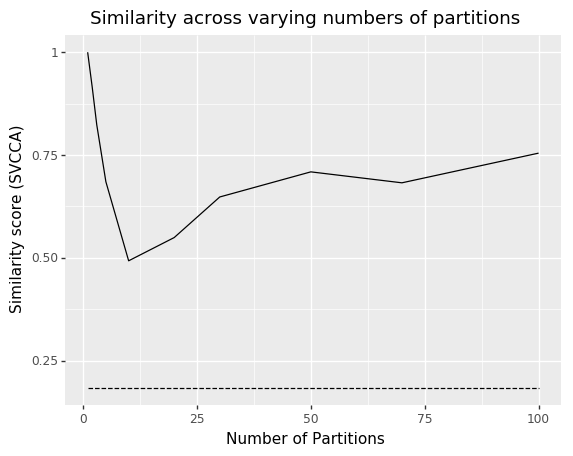

<ggplot: (8794953074766)>


In [17]:
# Plot
threshold = pd.DataFrame(
    pd.np.tile(
        permuted_score,
        (len(lst_num_partitions), 1)),
    index=lst_num_partitions,
    columns=['score'])

g = ggplot(similarity_score_df, aes(x=lst_num_partitions, y='score')) \
    + geom_line() \
    + geom_line(aes(x=lst_num_partitions, y='score'), threshold, linetype='dashed') \
    + xlab('Number of Partitions') \
    + ylab('Similarity score (SVCCA)') \
    + ggtitle('Similarity across varying numbers of partitions')

print(g)
ggsave(plot=g, filename=svcca_file, dpi=300)